# Introduction
Hey people, welcome to this kernel. In this kernel I'm gonna show you how to build a convolutional neural network using Pytorch.

I used to work with Tensorflow, but recently I decided to change my main deep learning library as Pytorch. I've researched both Tensorflow and Pytorch (really) detailed and Pytorch seems better for me.

So let's start! 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# Preparing Dataset
Pytorch offers advanced tools for reading,batching and preparing image data and today we'll use those tools.

In general, preparing data in pytorch have 3 steps.

**1. Preparing Dataset Class**

**2. Preparing Sampler**

**3. Preparing Data Loader**


### 1. Preparing Dataset Class
First, we'll create a dataset class by inheriting our class Pytorch's abstract Dataset class. There are some special functions we must override. We'll see them in the code.

In [2]:
# * We'll use this class to control the things.
# * 다양한 상황에서 발생할 수 있는 예외를 제어하기 위해 이 클래스 사용
class InvalidDatasetException(Exception):
    
    # 생성자 메소드 정의
    def __init__(self, len_of_paths, len_of_labels):
        # 부모 클래스의 생성자 호출 및 예외 메시지 설정
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )
        # 예외 메시지에 경로의 수와 레이블의 수를 포함하여 설정

In [3]:
# 이미지 변환 작업을 일괄적으로 처리하기 위해 Compose 사용
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
class AnimalDataset(Dataset):
    
    # 생성자 메소드 정의
    def __init__(self, img_paths, img_labels, size_of_images):
        self.img_paths = img_paths  # 이미지 경로 리스트 저장
        self.img_labels = img_labels  # 이미지 레이블 리스트 저장
        self.size_of_images = size_of_images  # 이미지 크기 저장
        if len(self.img_paths) != len(self.img_labels):
            # 이미지 경로와 레이블의 수가 일치하지 않으면 예외 발생
            raise InvalidDatasetException(len(self.img_paths), len(self.img_labels))
        
    # __len__ 특수 메소드 오버라이드 필요
    def __len__(self):
        # 데이터셋의 크기 반환
        return len(self.img_paths)
    
    # __getitem__ 특수 메소드 오버라이드 필요
    # 이 메소드는 주어진 인덱스에서 이미지와 해당 레이블을 반환해야 함
    def __getitem__(self, index):
        # 주어진 인덱스에서 이미지를 열고, 지정된 크기로 리사이즈
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images)
        # PyTorch에서는 텐서를 사용하므로, ToTensor 변환을 이용하여 PIL 이미지를 텐서로 변환
        TENSOR_IMAGE = transform(PIL_IMAGE)
        # 주어진 인덱스에서 레이블 가져오기
        label = self.img_labels[index]
        
        # 텐서 이미지와 레이블 반환
        return TENSOR_IMAGE, label

* If we want briefly explain what does this class do, it reads the image and convert it to a Torch tensor. Then it returns the image and the label of the image.

* Let's create our object. 

In [5]:
paths = []  # 이미지 경로를 저장할 리스트
labels = []  # 이미지 레이블을 저장할 리스트
label_map = {
    0: "Cat",  # 레이블 0은 "Cat"으로 매핑
    1: "Dog",  # 레이블 1은 "Dog"으로 매핑
    2: "Wild"  # 레이블 2는 "Wild"로 매핑
}

# 고양이 이미지 경로를 리스트에 추가하고, 레이블 0을 추가
for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)
    
# 개 이미지 경로를 리스트에 추가하고, 레이블 1을 추가
for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)
    
# 야생 동물 이미지 경로를 리스트에 추가하고, 레이블 2를 추가
for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)
    
# 이미지 경로의 수 출력
print(len(paths))
# 레이블의 수 출력
print(len(labels))

16130
16130


In [6]:
# AnimalDataset 객체 생성
dataset = AnimalDataset(paths, labels, (250, 250))

* We've completed the hardest part of preparing data. Now we'll create our sampler object.
* Basically sampler shows how we'll choose the data.
* We'll create two random samplers: Train Random Sampler and Test Random Sampler.
* These random samplers will randomly choose indices from the list given. You'll definitely understand when you see. Let's code it.

### 2. Preparing Sampler Objects

In [7]:
from sklearn.model_selection import train_test_split

# dataset_indices = [0,1,2,3,..len(dataset)-1]
# 데이터셋의 인덱스를 생성하여 리스트로 저장
dataset_indices = list(range(0, len(dataset)))

# 데이터셋 인덱스를 80%의 훈련 세트와 20%의 테스트 세트로 분할
train_indices, test_indices = train_test_split(dataset_indices, test_size=0.2, random_state=42)

# 훈련 샘플의 수 출력
print("Number of train samples: ", len(train_indices))
# 테스트 샘플의 수 출력
print("Number of test samples: ", len(test_indices))

Number of train samples:  12904
Number of test samples:  3226


* And now all we need to do is giving these indices lists to our samplers.

In [8]:
# 훈련 데이터셋에서 무작위로 샘플링하기 위한 샘플러 생성
train_sampler = SubsetRandomSampler(train_indices)
# 테스트 데이터셋에서 무작위로 샘플링하기 위한 샘플러 생성
test_sampler = SubsetRandomSampler(test_indices)

### 3. Preparing Data Loader Objects
Everything is ready to combine. We have a dataset we can read images and labels. We have samplers which will help us to randomly choose samples. And now we need a data loader which will create batches using the dataset and samplers.

In [9]:
BATCH_SIZE = 128  # 배치 크기 설정

# 훈련 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)

# 검증 데이터 로더 생성
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

* Everything is ready about data. Let's move on to the neural network modeling.


But before, let's take a look at our images.

In [10]:
dataset[1][0].shape  # 데이터셋의 두 번째 샘플의 첫 번째 요소(이미지)의 형태 출력

torch.Size([3, 250, 250])

In [11]:
# 훈련 데이터 로더에서 첫 번째 배치를 가져와 이미지와 레이블로 분리
images, labels = next(iter(train_loader))

# 레이블의 데이터 타입 출력
type(labels)

torch.Tensor

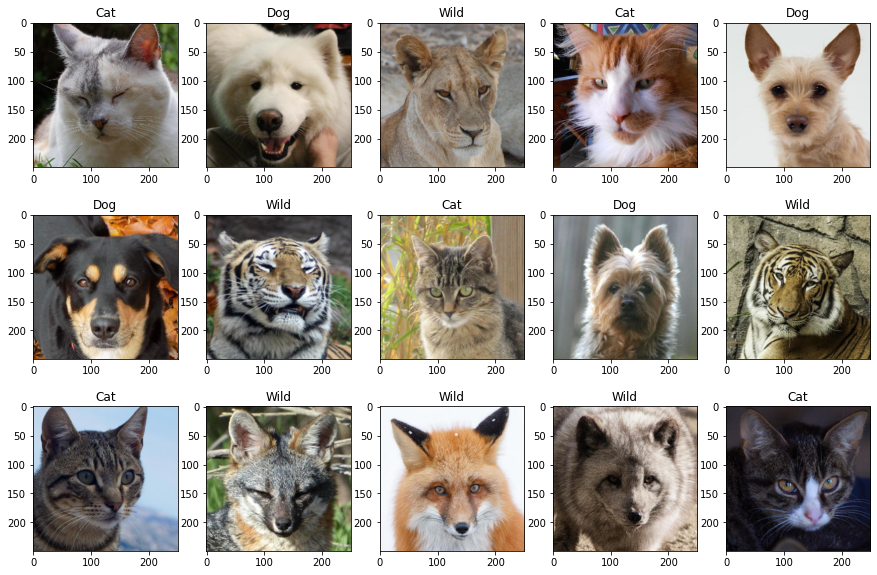

In [12]:
# 훈련 데이터 로더에서 첫 번째 배치를 가져와 이미지와 레이블로 분리
images, labels = iter(train_loader).next()

# 3x5 크기의 서브플롯 생성 (총 15개의 플롯)
fig, axis = plt.subplots(3, 5, figsize=(15, 10))

# 각 서브플롯에 이미지와 레이블을 추가
for i, ax in enumerate(axis.flat):
    with torch.no_grad():  # 그래디언트 계산 비활성화
        npimg = images[i].numpy()  # 이미지를 넘파이 배열로 변환
        npimg = np.transpose(npimg, (1, 2, 0))  # 이미지 차원 변환 (C, H, W) -> (H, W, C)
        label = label_map[int(labels[i])]  # 레이블 매핑
        ax.imshow(npimg)  # 이미지 표시
        ax.set(title=f"{label}")  # 서브플롯 제목 설정

# Neural Network Modeling
Our dataset is ready, now we can build our deep convolutional neural network. In Pytorch, when we build a model, we create a class inherited Pytorch's nn.Module abstract class.

Then we need to write forward function which includes forward propagation.

In [13]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # 레이어 정의
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 첫 번째 합성곱 레이어
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  
        self.batchnorm1 = nn.BatchNorm2d(64)  # 첫 번째 배치 정규화 레이어
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  
        self.batchnorm2 = nn.BatchNorm2d(128)  
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  
        self.batchnorm3 = nn.BatchNorm2d(256)  
        
        self.maxpool = nn.MaxPool2d(2, 2)  # 최대 풀링 레이어
        
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(512, 3) 
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 첫 번째 합성곱 레이어를 통과한 후 ReLU 활성화 함수 적용
        x = F.relu(self.conv2(x))  
        x = self.batchnorm1(x)  # 첫 번째 배치 정규화 적용
        x = self.maxpool(x)  # 최대 풀링 적용
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)  # 두 번째 배치 정규화 적용
        x = self.maxpool(x)  
        x = F.relu(self.conv4(x))  
        x = self.batchnorm3(x)  
        x = self.maxpool(x) 
        x = x.view(-1, 256 * 2 * 2)  # 텐서를 일렬로 펼침
        x = self.fc1(x)  # 첫 번째 완전 연결 레이어 통과
        x = self.fc2(x) 
        x = F.log_softmax(x, dim=1)  # 소프트맥스 활성화 함수 적용하여 로그 확률 계산
        return x


* Now we can create our model object. 
* But before we need to create our GPU variable, we'll send our model to the gpu that way.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda')

In [16]:
# CNN 모델 인스턴스 생성 후 지정된 장치로 이동
model = CNN().to(device)

Also as you know, in deep learning we use an optimization algorithm to apply gradients and a loss function to compute gradients. In this kernel we're going to use cross entropy loss and RMSProp optimizer.

In [17]:
# 손실 함수로 교차 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()

# 옵티마이저로 RMSprop 사용, 학습률 설정
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Training Model
Our model and dataset are ready, now we can train our model.

In [18]:
# 총 에포크 수 설정
EPOCH_NUMBER = 5

# 학습 손실과 학습 정확도를 저장할 리스트 초기화
TRAIN_LOSS = []
TRAIN_ACCURACY = []

# 에포크 반복
for epoch in range(1, EPOCH_NUMBER + 1):
    epoch_loss = 0.0  # 에포크 손실 초기화
    correct = 0  # 올바르게 예측한 수 초기화
    total = 0  # 총 데이터 수 초기화
    
    # 학습 데이터 로더에서 배치 반복
    for data_, target_ in train_loader:
        # 레이블을 원-핫 인코딩으로 변환
        target_ = target_.to(device)
        data_ = data_.to(device)
        
        # 캐시된 그래디언트 초기화
        optimizer.zero_grad()
        
        # 모델 예측 및 손실 계산
        outputs = model(data_)
        loss = criterion(outputs, target_)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        # 통계 계산
        epoch_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
    
    # 통계 리스트에 추가
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    
    # 에포크 결과 출력
    print(f"Epoch {epoch}: Accuracy: {100 * correct / total}, Loss: {epoch_loss}")

Epoch 1: Accuracy: 83.98946063236205, Loss: 45.40784879028797
Epoch 2: Accuracy: 95.60601363918165, Loss: 13.175120700150728
Epoch 3: Accuracy: 98.27185368877868, Loss: 6.008951224386692
Epoch 4: Accuracy: 99.5040297582145, Loss: 2.649179346859455
Epoch 5: Accuracy: 99.94575325480471, Loss: 1.0075058843940496


**We've trained our model, and now we can take a look at the stats and after that we can evaluate our model by using test set.**

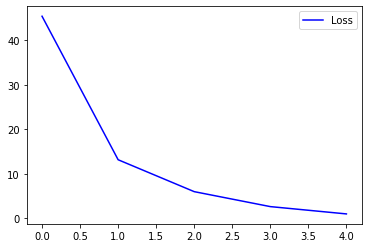

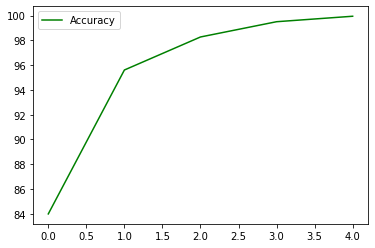

In [19]:
# 손실 그래프 그리기
plt.subplots(figsize=(6, 4))  # 그래프 크기 설정
plt.plot(range(EPOCH_NUMBER), TRAIN_LOSS, color="blue", label="Loss")  # 손실 값 플롯
plt.legend()  # 범례 추가
plt.show()  # 그래프 표시

# 정확도 그래프 그리기
plt.subplots(figsize=(6, 4))  # 그래프 크기 설정
plt.plot(range(EPOCH_NUMBER), TRAIN_ACCURACY, color="green", label="Accuracy")  # 정확도 값 플롯
plt.legend()  # 범례 추가
plt.show()  # 그래프 표시

# Final Test
And now we'll test our model using our test loader.

In [20]:
total_val_loss = 0.0  # 총 검증 손실 초기화
total_true = 0  # 올바르게 예측한 총 수 초기화
total = len(test_sampler)  # 테스트 샘플러의 총 데이터 수

# 그래디언트와 역전파를 사용하지 않을 때는 torch.no_grad() 유틸리티 사용
with torch.no_grad():
    model.eval()  # 모델을 평가 모드로 전환
    for data_, target_ in validation_loader:
        data_ = data_.to(device)  # 데이터를 장치로 이동
        target_ = target_.to(device)  # 타겟을 장치로 이동
        
        outputs = model(data_)  # 모델 예측
        loss = criterion(outputs, target_).item()  # 손실 계산
        _, preds = torch.max(outputs, dim=1)  # 예측값의 최대값 인덱스 추출
        total_val_loss += loss  # 총 검증 손실에 현재 손실 더하기
        true = torch.sum(preds == target_).item()  # 올바르게 예측한 수 계산
        total_true += true  # 총 올바르게 예측한 수에 더하기

validation_accuracy = round(100 * total_true / total, 2)  # 검증 정확도 계산
print(f"Validation accuracy: {validation_accuracy}%")  # 검증 정확도 출력
print(f"Validation loss: {round(total_val_loss, 2)}%")  # 검증 손실 출력

Validation accuracy: 95.66%
Validation loss: 3.47%


* And boom, our model is ready to use!

# How to Save A Pytorch Model
We trained our model and we might want to use it in our real life. And in order to use it regularly we need to save it.

There are lots of way to save a model in Pytorch but today we'll use the best way: saving state dict.


State dictionary is a python dictionary which includes layer names as keys and layer weights as items. If we take a look at the state dict we can fully understand it.

In [21]:
# 모델의 상태 딕셔너리에서 각 파라미터 텐서와 그 크기를 출력
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
batchnorm1.weight 	 torch.Size([64])
batchnorm1.bias 	 torch.Size([64])
batchnorm1.running_mean 	 torch.Size([64])
batchnorm1.running_var 	 torch.Size([64])
batchnorm1.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
batchnorm2.weight 	 torch.Size([128])
batchnorm2.bias 	 torch.Size([128])
batchnorm2.running_mean 	 torch.Size([128])
batchnorm2.running_var 	 torch.Size([128])
batchnorm2.num_batches_tracked 	 torch.Size([])
conv4.weight 	 torch.Size([256, 128, 3, 3])
conv4.bias 	 torch.Size([256])
batchnorm3.weight 	 torch.Size([256])
batchnorm3.bias 	 torch.Size([256])
batchnorm3.running_mean 	 torch.Size([256])
batchnorm3.running_var 	 torch.Size([256])
batchnorm3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([512, 1024])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.

* And as you guess, we can just save and load this state dict.

In [22]:
# 모델의 상태 딕셔너리를 "model.pt" 파일로 저장
torch.save(model.state_dict(), "model.pt")

* And in order to load model we need to create a new object from the class and load the state dict.

In [23]:
# 새로운 모델 인스턴스 생성
loaded_model = CNN()

# "model.pt" 파일에서 모델 상태 딕셔너리를 로드하여 모델에 적용
loaded_model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

# Conclusion
Thanks for your attention. If you have a question, plase share it with me. It's a pleasure for me to help you. Have a good day!